# MOSAIC Verification - Layer 4: Channel 3 Funding Mechanisms

Extended funding analysis for Universal High Income (UHI) scenarios.

**Dependencies:** config.py, functions.py

**Key Data Sources:**
- Berl Institute 2020: Israeli household wealth distribution
- Piketty 2010: Annual inheritance flow estimate (3%)
- Israel Natural Gas Authority 2024: Gas production & wealth fund benchmark
- Jerusalem Post 2025: Household data usage forecast (1 TB/month by 2030)
- BOI 2024: Pillar Two tax loss estimate (0.3% GDP)
- Globes 2024: NVIDIA tax benefits case (~10B)
- Kohelet Policy Forum: UBI consolidation estimates

In [1]:
# Standard imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# MOSAIC verification imports
from config import DATA
from functions import load_calc, store, get, CALC

# Initialize CALC from disk
load_calc()
print(f"CALC initialized with {sum(len(v) for v in CALC.values())} values")

CALC initialized with 0 values


---
# 4.1 Wealth Distribution Data

**Source:** [Berl Institute 2020](https://telem.berl.org.il/11775/)

| Statistic | Value | Description |
|-----------|-------|-------------|
| W01 | 6.5T NIS | Total net wealth of Israeli households |
| W02 | 14.1M NIS | Average wealth per household, top decile |
| W03 | 50% | Share of total wealth held by top decile |
| W04 | 25% | Share of total wealth held by top percentile |
| W05 | 55M+ NIS | Minimum wealth per household, top percentile |

In [2]:
print("=" * 70)
print("4.1 WEALTH DISTRIBUTION DATA (Berl Institute 2020)")
print("=" * 70)

# =============================================================================
# WEALTH DISTRIBUTION DATA - from DATA dict
# Source: https://telem.berl.org.il/11775/
# =============================================================================

# Load from DATA
wealth_total = get('wealth_total_2020')  # B NIS
wealth_top_decile_share = get('wealth_top_decile_share') / 100  # Convert % to fraction
wealth_top_percentile_share = get('wealth_top_percentile_share') / 100
wealth_top_decile_avg = get('wealth_top_decile_avg')  # M NIS
wealth_top_percentile_min = get('wealth_top_percentile_min')  # M NIS

# Store to CALC (already in proper units from DATA)
store('wealth_total_2020', wealth_total, 'layer4')
store('wealth_top_decile_share', wealth_top_decile_share, 'layer4')
store('wealth_top_percentile_share', wealth_top_percentile_share, 'layer4')

# Derived values
wealth_top_decile = wealth_total * wealth_top_decile_share  # B NIS
wealth_top_percentile = wealth_total * wealth_top_percentile_share  # B NIS

store('wealth_top_decile_total', wealth_top_decile, 'layer4')
store('wealth_top_percentile_total', wealth_top_percentile, 'layer4')

print(f"\nIsraeli Household Wealth (2020):")
print(f"  Total net wealth: {wealth_total/1000:.1f}T NIS")
print(f"")
print(f"Top Decile:")
print(f"  Share of total: {wealth_top_decile_share*100:.0f}%")
print(f"  Total wealth: {wealth_top_decile/1000:.2f}T NIS")
print(f"  Average per HH: {wealth_top_decile_avg:.1f}M NIS")
print(f"")
print(f"Top Percentile:")
print(f"  Share of total: {wealth_top_percentile_share*100:.0f}%")
print(f"  Total wealth: {wealth_top_percentile/1000:.3f}T NIS")
print(f"  Minimum per HH: >{wealth_top_percentile_min:.0f}M NIS")
print(f"")
print(f"Source: Berl Institute 2020")
print(f"URL: https://telem.berl.org.il/11775/")

4.1 WEALTH DISTRIBUTION DATA (Berl Institute 2020)

Israeli Household Wealth (2020):
  Total net wealth: 6.5T NIS

Top Decile:
  Share of total: 50%
  Total wealth: 3.25T NIS
  Average per HH: 14.1M NIS

Top Percentile:
  Share of total: 25%
  Total wealth: 1.625T NIS
  Minimum per HH: >55M NIS

Source: Berl Institute 2020
URL: https://telem.berl.org.il/11775/


---
# 4.2 Estate Tax Revenue Calculation

**Methodology:**
1. Annual inheritance flow = μ × W (where μ ≈ 3%)
2. Estate tax revenue = τ_estate × annual_flow

**Key assumption:** μ = 3% annual inheritance flow rate

**Source:** [Piketty (2010)](http://piketty.pse.ens.fr/inheritance/Piketty2010WP.pdf)
- The ratio B/Y (annual inheritance flow to national income) has been ~3-4% historically
- This varies with mortality rate and relative wealth of decedents
- For Israel, we use μ = 3% as a conservative estimate

In [3]:
print("=" * 70)
print("4.2 ESTATE TAX REVENUE CALCULATION")
print("=" * 70)

# =============================================================================
# PARAMETERS - from DATA dict
# =============================================================================

# Annual inheritance flow rate (Piketty 2010)
# Source: http://piketty.pse.ens.fr/inheritance/Piketty2010WP.pdf
mu_inheritance = get('mu_inheritance') / 100  # Convert % to fraction

# Estate tax rate (policy parameter)
tau_estate = get('tau_estate') / 100  # Convert % to fraction

# High exemption threshold (policy design)
exemption_threshold = get('estate_exemption_threshold')  # M NIS

# Store to CALC
store('mu_inheritance', mu_inheritance, 'layer4')
store('tau_estate', tau_estate, 'layer4')
store('estate_exemption_threshold', exemption_threshold, 'layer4')

print(f"\nParameters (from DATA):")
print(f"  Annual inheritance flow rate (μ): {mu_inheritance*100:.0f}%")
print(f"  Estate tax rate (τ): {tau_estate*100:.0f}%")
print(f"  Exemption threshold: {exemption_threshold:.0f}M NIS")
print(f"")
print(f"Source: Piketty (2010) - 'On the Long-Run Evolution of Inheritance'")
print(f"Note: μ varies with mortality rate and relative wealth of decedents")

4.2 ESTATE TAX REVENUE CALCULATION

Parameters (from DATA):
  Annual inheritance flow rate (μ): 3%
  Estate tax rate (τ): 30%
  Exemption threshold: 5M NIS

Source: Piketty (2010) - 'On the Long-Run Evolution of Inheritance'
Note: μ varies with mortality rate and relative wealth of decedents


In [4]:
print("\n" + "=" * 70)
print("ESTATE TAX REVENUE (TOP DECILE)")
print("=" * 70)

# =============================================================================
# CALCULATION: ESTATE TAX ON TOP DECILE
# =============================================================================

# Wealth base (top decile only, due to high exemption threshold)
# wealth_top_decile is in B NIS (from cell-3)

# Annual inheritance flow from top decile
annual_inheritance_flow = wealth_top_decile * mu_inheritance  # B NIS

# Estate tax revenue
estate_tax_revenue = annual_inheritance_flow * tau_estate  # B NIS

# Store results
store('annual_inheritance_flow_top_decile', annual_inheritance_flow, 'layer4')
store('estate_tax_revenue', estate_tax_revenue, 'layer4')

print(f"\nCalculation (Top Decile):")
print(f"")
print(f"  Step 1: Wealth base")
print(f"    Total wealth in top decile: {wealth_top_decile/1000:.2f}T NIS")
print(f"    (50% of 6.5T total wealth)")
print(f"")
print(f"  Step 2: Annual inheritance flow")
print(f"    Flow = μ × Wealth = {mu_inheritance*100:.0f}% × {wealth_top_decile/1000:.2f}T")
print(f"    Flow = {annual_inheritance_flow:.1f}B NIS/year")
print(f"")
print(f"  Step 3: Estate tax revenue")
print(f"    Revenue = τ × Flow = {tau_estate*100:.0f}% × {annual_inheritance_flow:.1f}B")
print(f"    Revenue = {estate_tax_revenue:.1f}B NIS/year")
print(f"")
print(f"  " + "=" * 50)
print(f"  RESULT: {tau_estate*100:.0f}% estate tax on top decile = {estate_tax_revenue:.1f}B NIS/year")
print(f"  " + "=" * 50)


ESTATE TAX REVENUE (TOP DECILE)

Calculation (Top Decile):

  Step 1: Wealth base
    Total wealth in top decile: 3.25T NIS
    (50% of 6.5T total wealth)

  Step 2: Annual inheritance flow
    Flow = μ × Wealth = 3% × 3.25T
    Flow = 97.5B NIS/year

  Step 3: Estate tax revenue
    Revenue = τ × Flow = 30% × 97.5B
    Revenue = 29.2B NIS/year

  RESULT: 30% estate tax on top decile = 29.2B NIS/year


In [5]:
print("\n" + "=" * 70)
print("SENSITIVITY ANALYSIS: ESTATE TAX BY RATE AND COVERAGE")
print("=" * 70)

# =============================================================================
# SENSITIVITY: DIFFERENT TAX RATES
# =============================================================================

print(f"\n--- Tax Rate Sensitivity (Top Decile Base) ---")
print(f"  Wealth base: {wealth_top_decile/1000:.2f}T NIS")
print(f"  Annual flow: {annual_inheritance_flow:.1f}B NIS/year")
print(f"")
print(f"  {'Tax Rate':>10} {'Revenue (B)':>12} {'% of GDP*':>10}")
print("  " + "-" * 35)

Y0 = get('Y0')  # GDP in billions

for rate in [0.10, 0.20, 0.30, 0.40, 0.50]:
    revenue = annual_inheritance_flow * rate
    pct_gdp = revenue / Y0 * 100
    print(f"  {rate*100:>9.0f}% {revenue:>11.1f}B {pct_gdp:>9.2f}%")
    
    # Store key rates
    store(f'estate_tax_revenue_{int(rate*100)}pct', revenue, 'layer4')

print("  " + "-" * 35)
print(f"  *GDP (Y₀) = {Y0:,.0f}B NIS")

# =============================================================================
# SENSITIVITY: DIFFERENT COVERAGE (TOP DECILE VS TOP PERCENTILE)
# =============================================================================

print(f"\n--- Coverage Sensitivity ({tau_estate*100:.0f}% Tax Rate) ---")
print(f"")
print(f"  {'Coverage':>15} {'Wealth':>10} {'Flow':>10} {'Revenue':>10}")
print("  " + "-" * 50)

coverages = [
    ('Top Decile', wealth_top_decile),
    ('Top Percentile', wealth_top_percentile),
    ('All Households', wealth_total),
]

for name, wealth in coverages:
    flow = wealth * mu_inheritance
    rev = flow * tau_estate
    print(f"  {name:>15} {wealth/1000:>9.2f}T {flow:>9.1f}B {rev:>9.1f}B")

print("  " + "-" * 50)


SENSITIVITY ANALYSIS: ESTATE TAX BY RATE AND COVERAGE

--- Tax Rate Sensitivity (Top Decile Base) ---
  Wealth base: 3.25T NIS
  Annual flow: 97.5B NIS/year

    Tax Rate  Revenue (B)  % of GDP*
  -----------------------------------
         10%         9.8B      0.58%
         20%        19.5B      1.15%
         30%        29.2B      1.73%
         40%        39.0B      2.30%
         50%        48.8B      2.88%
  -----------------------------------
  *GDP (Y₀) = 1,694B NIS

--- Coverage Sensitivity (30% Tax Rate) ---

         Coverage     Wealth       Flow    Revenue
  --------------------------------------------------
       Top Decile      3.25T      97.5B      29.2B
   Top Percentile      1.62T      48.8B      14.6B
   All Households      6.50T     195.0B      58.5B
  --------------------------------------------------


---
# 4.6 Channel 3 Funding Summary

Updated funding table with calculated estate tax, data dividend, Pillar Two, and Yozma 2.0 revenue.

---
# 4.3 Natural Gas Benchmark & Data Dividend

**Natural Gas Benchmark ("Oil Drop"):**
- Source: [Israel Natural Gas Authority 2024](https://naturalgas.org.il/wp-content/uploads/2024/12/GAZ_V4_EN_1.pdf)
- 25 BCM production (2023) → 1B NIS to wealth fund = 0.04 NIS/m³

**Data Dividend Methodology:**
- Value personal data at 2.5× the natural gas rate (data is more valuable than oil)
- Household data forecast (2030): 1 TB/month ([Jerusalem Post 2025](https://www.jpost.com/israel-news/article-881253))
- Rate: 0.10 NIS/GB

In [6]:
print("=" * 70)
print("4.3 NATURAL GAS BENCHMARK & DATA DIVIDEND")
print("=" * 70)

# =============================================================================
# NATURAL GAS BENCHMARK ("Oil Drop")
# Source: https://naturalgas.org.il/wp-content/uploads/2024/12/GAZ_V4_EN_1.pdf
# =============================================================================

gas_production = get('gas_production_2023')      # BCM
wealth_fund = get('wealth_fund_transfer_2024')   # B NIS

# Calculate rate per cubic meter
gas_rate = wealth_fund / gas_production  # NIS per m³ (since BCM = billion m³)

store('gas_production_2023', gas_production, 'layer4')
store('wealth_fund_transfer_2024', wealth_fund, 'layer4')
store('gas_rate_nis_per_m3', gas_rate, 'layer4')

print(f"\n1. NATURAL GAS BENCHMARK ('Oil Drop')")
print("-" * 70)
print(f"   Gas production (2023): {gas_production} BCM")
print(f"   Wealth fund transfer:  {wealth_fund} B NIS")
print(f"   Rate: {gas_rate:.2f} NIS/m³ = {gas_rate*100:.0f} agorot/m³")

# =============================================================================
# DATA DIVIDEND CALCULATION
# =============================================================================

households = get('total_households')  # M households
data_per_hh = get('data_per_hh_2030')  # GB/month
data_rate = get('data_rate_nis_per_gb')  # NIS/GB

# Annual data volume
annual_data_per_hh = data_per_hh * 12  # GB/year
total_annual_data = households * 1e6 * annual_data_per_hh  # GB total

# Data dividend revenue
data_dividend_calc = total_annual_data * data_rate / 1e9  # B NIS

store('data_per_hh_2030', data_per_hh, 'layer4')
store('data_rate_nis_per_gb', data_rate, 'layer4')
store('total_annual_data_gb', total_annual_data / 1e9, 'layer4')  # In billions
store('data_dividend_calculated', data_dividend_calc, 'layer4')

print(f"\n2. DATA DIVIDEND CALCULATION")
print("-" * 70)
print(f"   Households: {households:.2f}M")
print(f"   Data per household: {data_per_hh/1000:.0f} TB/month = {data_per_hh:,} GB/month")
print(f"   Annual per household: {annual_data_per_hh:,} GB/year")
print(f"   Total annual data: {total_annual_data/1e9:.2f} billion GB")
print(f"")
print(f"   Data rate: {data_rate:.2f} NIS/GB (vs gas: {gas_rate:.2f} NIS/m³)")
print(f"   Ratio to gas: {data_rate/gas_rate:.1f}× (valuing data > oil)")
print(f"")
print(f"   Revenue = {total_annual_data/1e9:.2f}B GB × {data_rate:.2f} NIS/GB")
print(f"          = {data_dividend_calc:.1f}B NIS/year")

print(f"\n" + "=" * 70)
print(f"RESULT: Data dividend at {data_rate:.2f} NIS/GB = {data_dividend_calc:.1f}B NIS/year")
print(f"        Per household: {annual_data_per_hh * data_rate:.0f} NIS/year = {annual_data_per_hh * data_rate / 12:.0f} NIS/month")
print("=" * 70)

4.3 NATURAL GAS BENCHMARK & DATA DIVIDEND

1. NATURAL GAS BENCHMARK ('Oil Drop')
----------------------------------------------------------------------
   Gas production (2023): 25 BCM
   Wealth fund transfer:  1 B NIS
   Rate: 0.04 NIS/m³ = 4 agorot/m³

2. DATA DIVIDEND CALCULATION
----------------------------------------------------------------------
   Households: 2.98M
   Data per household: 1 TB/month = 1,000 GB/month
   Annual per household: 12,000 GB/year
   Total annual data: 35.75 billion GB

   Data rate: 0.10 NIS/GB (vs gas: 0.04 NIS/m³)
   Ratio to gas: 2.5× (valuing data > oil)

   Revenue = 35.75B GB × 0.10 NIS/GB
          = 3.6B NIS/year

RESULT: Data dividend at 0.10 NIS/GB = 3.6B NIS/year
        Per household: 1200 NIS/year = 100 NIS/month


---
# 4.4 Pillar Two Expansion (15% → 23%)

**Proposal:** Raise OECD global minimum tax from 15% to 23% (Israel's corporate rate)

**Sources:**
- [BOI 2024: Pillar Two Policy Paper](https://www.boi.org.il/en/communication-and-publications/press-releases/new-research-department-policy-paper-the-two-pillar-reform-of-the-international-taxation-of-multinational-corporations-challenges-and-policy-recommendations) - Israel loses 0.3% GDP to MNE tax incentives
- [Globes: NVIDIA Tax Benefits](https://en.globes.co.il/en/article-nvidia-in-advanced-talks-in-israel-over-new-tax-benefits-1001499318) - ~10B NIS/year recurring
- [EY/OECD: Pillar Impact](https://www.ey.com/en_gl/technical/tax-alerts/oecd-releases-updated-estimates-of-the-economic-impact-of-pillar) - Profit shifting ~50% losses

**Note:** Requires global cooperation to implement.

In [7]:
print("=" * 70)
print("4.4 PILLAR TWO EXPANSION (15% → 23%)")
print("=" * 70)

# =============================================================================
# PILLAR TWO EXPANSION - Raise global minimum from 15% to 23%
# =============================================================================

# Parameters from DATA
tax_loss_pct = get('pillar_two_tax_loss_pct_gdp') / 100  # 0.3% of GDP
current_loss = get('pillar_two_current_loss')  # 6B at Y0
nvidia_annual = get('pillar_two_nvidia_example')  # 10B/year recurring

# GDP values
Y0 = get('Y0')
Y1_agi = get('Y_1_agi')

# Calculate loss at Y1 (scales with GDP)
loss_at_Y1 = tax_loss_pct * Y1_agi

store('pillar_two_tax_loss_pct', tax_loss_pct, 'layer4')
store('pillar_two_current_loss', current_loss, 'layer4')
store('pillar_two_loss_at_Y1', loss_at_Y1, 'layer4')
store('pillar_two_nvidia_annual', nvidia_annual, 'layer4')

print(f"\n1. MNE TAX INCENTIVE LOSS (BOI 2024)")
print("-" * 70)
print(f"   Tax loss rate: {tax_loss_pct*100:.1f}% of GDP")
print(f"   Current loss (Y₀ = {Y0:.0f}B): {current_loss:.0f}B NIS/year")
print(f"   Loss at Y₁ (AGI = {Y1_agi:.0f}B): {loss_at_Y1:.1f}B NIS/year")

print(f"\n2. SUBJECT-TO-TAX CASES (NVIDIA Example)")
print("-" * 70)
print(f"   NVIDIA-type case: ~{nvidia_annual:.0f}B NIS/year (recurring annual)")
print(f"   Represents large MNEs currently receiving tax benefits")

print(f"\n3. PROFIT SHIFTING (EY/OECD)")
print("-" * 70)
print(f"   Estimated losses: ~50% of potential tax base")
print(f"   Hard to quantify for Israel-specific revenue")

# Total Pillar Two expansion revenue
# Both components are recurring annual revenue
pillar_two_mne_only = loss_at_Y1
pillar_two_total = loss_at_Y1 + nvidia_annual

store('pillar_two_revenue_mne_only', pillar_two_mne_only, 'layer4')
store('pillar_two_revenue_total', pillar_two_total, 'layer4')

print(f"\n" + "=" * 70)
print(f"PILLAR TWO EXPANSION REVENUE (at Y₁ = {Y1_agi:.0f}B)")
print("=" * 70)
print(f"   MNE incentive capture (0.3% GDP): {pillar_two_mne_only:.1f}B NIS/year")
print(f"   Subject-to-tax cases (NVIDIA):   {nvidia_annual:.0f}B NIS/year")
print(f"   ─────────────────────────────────────────────")
print(f"   TOTAL:                           {pillar_two_total:.1f}B NIS/year")
print(f"")
print(f"   (Requires 15% → 23% global minimum tax reform)")

# Use total for Channel 3 summary (both are recurring)
pillar_two_calc = pillar_two_total

4.4 PILLAR TWO EXPANSION (15% → 23%)

1. MNE TAX INCENTIVE LOSS (BOI 2024)
----------------------------------------------------------------------
   Tax loss rate: 0.3% of GDP
   Current loss (Y₀ = 1694B): 6B NIS/year
   Loss at Y₁ (AGI = 2875B): 8.6B NIS/year

2. SUBJECT-TO-TAX CASES (NVIDIA Example)
----------------------------------------------------------------------
   NVIDIA-type case: ~10B NIS/year (recurring annual)
   Represents large MNEs currently receiving tax benefits

3. PROFIT SHIFTING (EY/OECD)
----------------------------------------------------------------------
   Estimated losses: ~50% of potential tax base
   Hard to quantify for Israel-specific revenue

PILLAR TWO EXPANSION REVENUE (at Y₁ = 2875B)
   MNE incentive capture (0.3% GDP): 8.6B NIS/year
   Subject-to-tax cases (NVIDIA):   10B NIS/year
   ─────────────────────────────────────────────
   TOTAL:                           18.6B NIS/year

   (Requires 15% → 23% global minimum tax reform)


---
# 4.5 Government VC Fund (Yozma 2.0)

**Proposal:** Expand government VC investment based on the successful Yozma model

**Source:** [OECD: Benchmarking Government Support for VC - Israel](https://www.oecd.org/en/publications/benchmarking-government-support-for-venture-capital_82cd3fe1-en/israel_b5c8cc2e-en.html)

**Parameters:**
- Israeli VC gross IRR: 15-20% (10-15 year average)
- Investment horizon: 5 years (to 2030)
- Dividend: 5% of accumulated profits

In [8]:
print("=" * 70)
print("4.5 GOVERNMENT VC FUND (YOZMA 2.0)")
print("=" * 70)

# =============================================================================
# YOZMA 2.0 - Government VC Fund
# Source: OECD Benchmarking Government Support for VC - Israel
# =============================================================================

# Parameters from DATA
vc_gross_irr = get('vc_gross_irr') / 100  # 17.5%
vc_net_irr = get('vc_net_irr') / 100      # 13%
vc_initial = get('vc_initial_investment')  # 50B NIS
vc_years = int(get('vc_investment_horizon'))  # 5 years
vc_dividend_rate = get('vc_dividend_rate') / 100  # 5%

# Store parameters
store('vc_gross_irr', vc_gross_irr, 'layer4')
store('vc_initial_investment', vc_initial, 'layer4')
store('vc_investment_horizon', vc_years, 'layer4')
store('vc_dividend_rate', vc_dividend_rate, 'layer4')

print(f"\nParameters (from DATA):")
print(f"  Gross IRR: {vc_gross_irr*100:.1f}% (Israeli VC 10-15yr avg)")
print(f"  Initial investment: {vc_initial:.0f}B NIS")
print(f"  Investment horizon: {vc_years} years (to 2030)")
print(f"  Dividend rate: {vc_dividend_rate*100:.0f}% of profits")

# Calculate growth
growth_factor = (1 + vc_gross_irr) ** vc_years
vc_final_value = vc_initial * growth_factor
vc_profit = vc_final_value - vc_initial
vc_annual_dividend = vc_profit * vc_dividend_rate

store('vc_growth_factor', growth_factor, 'layer4')
store('vc_final_value', vc_final_value, 'layer4')
store('vc_profit', vc_profit, 'layer4')
store('vc_annual_dividend', vc_annual_dividend, 'layer4')

print(f"\n" + "-" * 70)
print(f"CALCULATION")
print("-" * 70)
print(f"  Growth factor ({vc_years}yr at {vc_gross_irr*100:.1f}%): {growth_factor:.2f}x")
print(f"  Initial investment: {vc_initial:.0f}B NIS")
print(f"  Value in 2030: {vc_final_value:.1f}B NIS")
print(f"  Profit: {vc_profit:.1f}B NIS")
print(f"  5% dividend on profit: {vc_annual_dividend:.1f}B NIS/year")

print(f"\n" + "=" * 70)
print(f"RESULT: Yozma 2.0 dividend = {vc_annual_dividend:.1f}B NIS/year (from 2030)")
print("=" * 70)

# Sensitivity analysis
print(f"\nSensitivity by Initial Investment (at {vc_gross_irr*100:.1f}% IRR):")
print(f"  {'Initial':>10} {'Value 2030':>12} {'Profit':>10} {'Dividend':>12}")
print("  " + "-" * 48)
for init in [25, 50, 100]:
    val = init * growth_factor
    prof = val - init
    div = prof * vc_dividend_rate
    marker = " <--" if init == vc_initial else ""
    print(f"  {init:>9}B {val:>11.1f}B {prof:>9.1f}B {div:>11.1f}B/yr{marker}")

# Use calculated dividend for Channel 3
yozma_dividend = vc_annual_dividend

4.5 GOVERNMENT VC FUND (YOZMA 2.0)

Parameters (from DATA):
  Gross IRR: 17.5% (Israeli VC 10-15yr avg)
  Initial investment: 50B NIS
  Investment horizon: 5 years (to 2030)
  Dividend rate: 5% of profits

----------------------------------------------------------------------
CALCULATION
----------------------------------------------------------------------
  Growth factor (5yr at 17.5%): 2.24x
  Initial investment: 50B NIS
  Value in 2030: 112.0B NIS
  Profit: 62.0B NIS
  5% dividend on profit: 3.1B NIS/year

RESULT: Yozma 2.0 dividend = 3.1B NIS/year (from 2030)

Sensitivity by Initial Investment (at 17.5% IRR):
     Initial   Value 2030     Profit     Dividend
  ------------------------------------------------
         25B        56.0B      31.0B         1.5B/yr
         50B       112.0B      62.0B         3.1B/yr <--
        100B       224.0B     124.0B         6.2B/yr


---
# 4.5b UHI Target Cost Calculation

**Purpose:** Calculate the cost of the UHI floor from first principles using CBS decile data.

**Parameters:**
- UHI floor: 15,000 NIS/month per adult-equivalent
- Taper rate: 50%
- Disregard: 2,500 NIS/month
- Take-up rate: 85%

**Method:** Sum NIT benefits across all deciles at the UHI floor level.

In [9]:
print("=" * 70)
print("4.5b UHI TARGET COST CALCULATION (MICROSIMULATION)")
print("=" * 70)

# =============================================================================
# CALCULATE UHI COST FROM FLOOR USING MICROSIMULATION
# Same methodology as layer3 for consistency
# =============================================================================

import pandas as pd
import numpy as np

# Import microsimulation functions (same as layer3)
from functions import (
    estimate_beta_concentration,
    estimate_gamma_shape,
    get_decile_bounds_gross,
    generate_decile_households,
)

# UHI floor from config
uhi_floor = get('uhi_floor_target')  # 15,000 NIS/mo

# NIT parameters - ALL from config (same as app)
taper = get('taper_implemented')  # 0.50
disregard = get('disregard')  # 1,000 NIS/mo
takeup = get('nit_take_up_rate') / 100  # 0.85

# Microsim parameters
N_SAMPLES = 1000
rng = np.random.default_rng(42)

# Load CBS 2022 household data (same source as layer3)
income_file = "data/cbs_household_income_2022.csv"
df = pd.read_csv(income_file)

# Build CBS_DECILES from the CSV (matching layer3 methodology)
CBS_DECILES = []
for _, row in df.iterrows():
    decile = int(row['decile'])
    gross = row['gross_income']
    net = row['net_income']
    std_persons = row['avg_std_persons']
    households = row['households_population_thousands'] * 1000
    upper_limit = row['upper_limit_nis'] if pd.notna(row['upper_limit_nis']) else None
    equiv_gross = gross / std_persons
    equiv_net = net / std_persons
    
    CBS_DECILES.append({
        'decile': decile,
        'gross_income': gross,
        'net_income': net,
        'equiv_gross': equiv_gross,
        'equiv_net': equiv_net,
        'std_persons': std_persons,
        'households': households,
        'upper_limit': upper_limit,
    })

CBS_DECILES = sorted(CBS_DECILES, key=lambda x: x['decile'])

# Estimate distribution parameters (matching layer3)
gross_means = [d['equiv_gross'] for d in CBS_DECILES]
net_means = [d['equiv_net'] for d in CBS_DECILES]
std_persons_means = [d['std_persons'] for d in CBS_DECILES]
upper_limits_net = [d['upper_limit'] for d in CBS_DECILES]

beta_concentration = estimate_beta_concentration(gross_means)
gamma_shape = estimate_gamma_shape(std_persons_means)

# Get decile bounds for income distributions (same as layer3)
decile_bounds = []
for i, d in enumerate(CBS_DECILES):
    lower, upper = get_decile_bounds_gross(
        decile=d['decile'],
        upper_net=upper_limits_net,
        gross_means=gross_means,
        net_means=net_means
    )
    decile_bounds.append((lower, upper))

# Calculate break-even
breakeven = disregard + uhi_floor / taper
median_wage = get('median_wage')

print("")
print("UHI Floor Parameters:")
print(f"  Floor M = {uhi_floor:,} NIS/mo")
print(f"  Couples floor = {int(uhi_floor * 1.5):,} NIS/mo")
print(f"  Floor as % of median = {uhi_floor/median_wage*100:.0f}%")
print(f"  Taper = {taper}")
print(f"  Disregard = {disregard:,} NIS/mo")
print(f"  Break-even y* = {breakeven:,.0f} NIS/mo")
print(f"  Take-up = {takeup*100:.0f}%")
print("")
print("Microsimulation Parameters:")
print(f"  Beta concentration: {beta_concentration:.2f}")
print(f"  Gamma shape: {gamma_shape:.2f}")
print(f"  Samples per decile: {N_SAMPLES}")

# Benefit calculation function
def calc_benefit_from_gross(equiv_gross, floor, taper, disregard):
    breakeven = disregard + floor / taper
    if equiv_gross >= breakeven:
        return 0
    taxable = max(0, equiv_gross - disregard)
    return max(0, floor - taper * taxable)

# Calculate cost using microsimulation
total_cost_100pct = 0
print("")
print(f"{'Decile':<8} {'Income':<12} {'Benefit':<12} {'HH Cost':<12} {'Annual':>12}")
print("-" * 60)

for i, d in enumerate(CBS_DECILES):
    lower, upper = decile_bounds[i]
    
    # Generate synthetic households (same as layer3)
    synth_hh = generate_decile_households(
        n=N_SAMPLES,
        mean_income=d['equiv_gross'],
        lower_income=lower,
        upper_income=upper,
        mean_std_persons=d['std_persons'],
        beta_concentration=beta_concentration,
        gamma_shape=gamma_shape,
        rng=rng
    )
    
    # Calculate microsim cost for this decile
    total_benefit_microsim = 0
    for hh in synth_hh:
        benefit_per_std = calc_benefit_from_gross(hh['equiv_gross'], uhi_floor, taper, disregard)
        total_benefit_microsim += benefit_per_std * hh['std_persons']
    
    avg_benefit_per_hh = total_benefit_microsim / N_SAMPLES
    annual_cost = avg_benefit_per_hh * d['households'] * 12 / 1e9
    total_cost_100pct += annual_cost
    
    if avg_benefit_per_hh > 0:
        print(f"D{d['decile']:<7} {d['equiv_gross']:>10,.0f} {avg_benefit_per_hh:>10,.0f} {avg_benefit_per_hh:>10,.0f} {annual_cost:>11.1f}B")
    else:
        print(f"D{d['decile']:<7} {d['equiv_gross']:>10,.0f} {'---':>10} {'---':>10} {'---':>11}")

print("-" * 60)
print(f"{'Total (100%)':40} {total_cost_100pct:>11.1f}B")

# Apply take-up rate
target_cost = total_cost_100pct * takeup
print(f"{'Total (85% take-up)':40} {target_cost:>11.1f}B")

# Store the calculated target cost
store('uhi_floor', uhi_floor, 'layer4')
store('uhi_breakeven', breakeven, 'layer4')
store('uhi_cost_100pct', total_cost_100pct, 'layer4')
store('uhi_target_cost', target_cost, 'layer4')

print("")
print("=" * 70)
print(f"RESULT: UHI target cost at {uhi_floor:,} NIS/mo floor = {target_cost:.0f}B NIS")
print(f"        (at 85% take-up; 100% would be {total_cost_100pct:.0f}B)")
print("=" * 70)

4.5b UHI TARGET COST CALCULATION (MICROSIMULATION)



UHI Floor Parameters:
  Floor M = 15,000 NIS/mo
  Couples floor = 22,500 NIS/mo
  Floor as % of median = 142%
  Taper = 0.5
  Disregard = 1,000 NIS/mo
  Break-even y* = 31,000 NIS/mo
  Take-up = 85%

Microsimulation Parameters:
  Beta concentration: 2.16
  Gamma shape: 85.12
  Samples per decile: 1000

Decile   Income       Benefit      HH Cost            Annual
------------------------------------------------------------
D1            1,877     47,935     47,935       167.7B
D2            3,263     41,587     41,587       145.9B
D3            4,358     34,685     34,685       121.2B
D4            5,291     34,276     34,276       120.5B
D5            6,622     31,203     31,203       109.3B
D6            7,812     29,481     29,481       103.4B
D7            9,278     27,131     27,131        95.0B
D8           11,244     23,840     23,840        83.6B
D9           14,586     18,819     18,819        65.9B
D10          23,974      8,101      8,101        28.5B
-----------------------

In [10]:
print("=" * 70)
print("4.6 CHANNEL 3 FUNDING SUMMARY (AGI SCENARIO)")
print("=" * 70)

# =============================================================================
# FUNDING COMPONENTS - from DATA dict and calculations above
# =============================================================================

# From existing MOSAIC model (Layer 2)
existing_revenue = get('revenue_agi')  # 191B

# Kohelet estimates (from DATA)
kohelet_consolidation = get('kohelet_consolidation')  # B NIS
kohelet_tax_reform = get('kohelet_tax_reform')        # B NIS

# Estate tax (calculated in section 4.2)
estate_tax = estate_tax_revenue  # B NIS

# Data dividend (calculated in section 4.3)
data_dividend = data_dividend_calc  # B NIS (3.6B)

# Pillar Two expansion (calculated in section 4.4 - includes NVIDIA)
pillar_two = pillar_two_calc  # B NIS (18.6B = 8.6 + 10)

# Yozma 2.0 VC fund (calculated in section 4.5)
yozma = yozma_dividend  # B NIS (3.1B)

# Target cost for 12,000 floor (couples = 18,000)
# target_cost already calculated in section 4.5b above

# Store to CALC
store('kohelet_consolidation', kohelet_consolidation, 'layer4')
store('kohelet_tax_reform', kohelet_tax_reform, 'layer4')
store('data_dividend_final', data_dividend, 'layer4')
store('pillar_two_final', pillar_two, 'layer4')
store('yozma_dividend_final', yozma, 'layer4')
store('uhi_target_cost', target_cost, 'layer4')

# Calculate windfall levy residual
other_sources = existing_revenue + kohelet_consolidation + kohelet_tax_reform + estate_tax + data_dividend + pillar_two + yozma
windfall_levy = max(0, target_cost - other_sources)
store('windfall_levy_required', windfall_levy, 'layer4')

# Capital measures
Y0 = get('Y0')
Y1_agi = get('Y_1_agi')
s_L = get('labor_share')
s_L_prime_agi = get('s_L_prime_agi')
s_K = 1 - s_L
s_K_prime = 1 - s_L_prime_agi

delta_W = s_K_prime * (Y1_agi - Y0)  # Growth windfall
delta_Pi = s_K_prime * Y1_agi - s_K * Y0  # Total capital change
store('delta_W_agi', delta_W, 'layer4')
store('delta_Pi_agi', delta_Pi, 'layer4')

print(f"\nTarget: 22,500 NIS/mo couples floor (M = 15,000 per adult-equivalent)")
print(f"Target cost: {target_cost}B NIS")
print(f"")
print(f"Capital Measures (AGI):")
print(f"  ΔW (growth windfall) = s_K' × (Y₁ - Y₀) = {delta_W:.0f}B")
print(f"  ΔΠ (total capital change) = s_K'Y₁ - s_KY₀ = {delta_Pi:.0f}B")
print(f"")
print(f"{'#':>2} {'Source':<32} {'Amount':>10} {'% of ΔΠ':>10}")
print("-" * 57)

components = [
    ('Existing (VAT+Ring-fencing)', existing_revenue),
    ('Consolidation (Kohelet)', kohelet_consolidation),
    ('Tax Reform (Kohelet)', kohelet_tax_reform),
    ('Estate Tax (30%, top decile)', estate_tax),
    ('Data Dividend (0.10 NIS/GB)', data_dividend),
    ('Pillar Two (15%→23% + NVIDIA)', pillar_two),
    ('Yozma 2.0 (VC dividend)', yozma),
    ('AI Windfall Levy', windfall_levy),
]

total = 0
for i, (name, amount) in enumerate(components, 1):
    pct_pi = amount / delta_Pi * 100 if delta_Pi > 0 else 0
    total += amount
    print(f"{i:>2} {name:<32} {amount:>9.1f}B {pct_pi:>9.1f}%")

print("-" * 57)
total_pct = total / delta_Pi * 100 if delta_Pi > 0 else 0
print(f"   {'TOTAL':<32} {total:>9.1f}B {total_pct:>9.1f}%")
store('channel3_total_funding', total, 'layer4')
store('channel3_capture_rate', total_pct, 'layer4')

print(f"")
print(f"New instruments: Estate ({estate_tax:.1f}B) + Data ({data_dividend:.1f}B) + Pillar Two ({pillar_two:.1f}B) + Yozma ({yozma:.1f}B) = {estate_tax+data_dividend+pillar_two+yozma:.1f}B")
print(f"Windfall levy = {windfall_levy:.1f}B ({windfall_levy/delta_Pi*100:.1f}% of ΔΠ)")

4.6 CHANNEL 3 FUNDING SUMMARY (AGI SCENARIO)

Target: 22,500 NIS/mo couples floor (M = 15,000 per adult-equivalent)
Target cost: 884.7915214480391B NIS

Capital Measures (AGI):
  ΔW (growth windfall) = s_K' × (Y₁ - Y₀) = 768B
  ΔΠ (total capital change) = s_K'Y₁ - s_KY₀ = 1123B

 # Source                               Amount    % of ΔΠ
---------------------------------------------------------
 1 Existing (VAT+Ring-fencing)          266.0B      23.7%
 2 Consolidation (Kohelet)               43.0B       3.8%
 3 Tax Reform (Kohelet)                  78.0B       6.9%
 4 Estate Tax (30%, top decile)          29.2B       2.6%
 5 Data Dividend (0.10 NIS/GB)            3.6B       0.3%
 6 Pillar Two (15%→23% + NVIDIA)         18.6B       1.7%
 7 Yozma 2.0 (VC dividend)                3.1B       0.3%
 8 AI Windfall Levy                     443.2B      39.5%
---------------------------------------------------------
   TOTAL                                884.8B      78.8%

New instruments: Estate

---
# 4.7 Capture Gap Waterfall (Figure for Paper Section 6)

Visualizes the "democratic choice" framing:
- Basic NIT (poverty elimination) is fully funded by the two-channel system
- UHI requires capturing additional automation surplus via third-channel mechanisms
- The "capture gap" represents uncaptured capital gains available for redistribution

4.7 CAPTURE GAP FIGURE


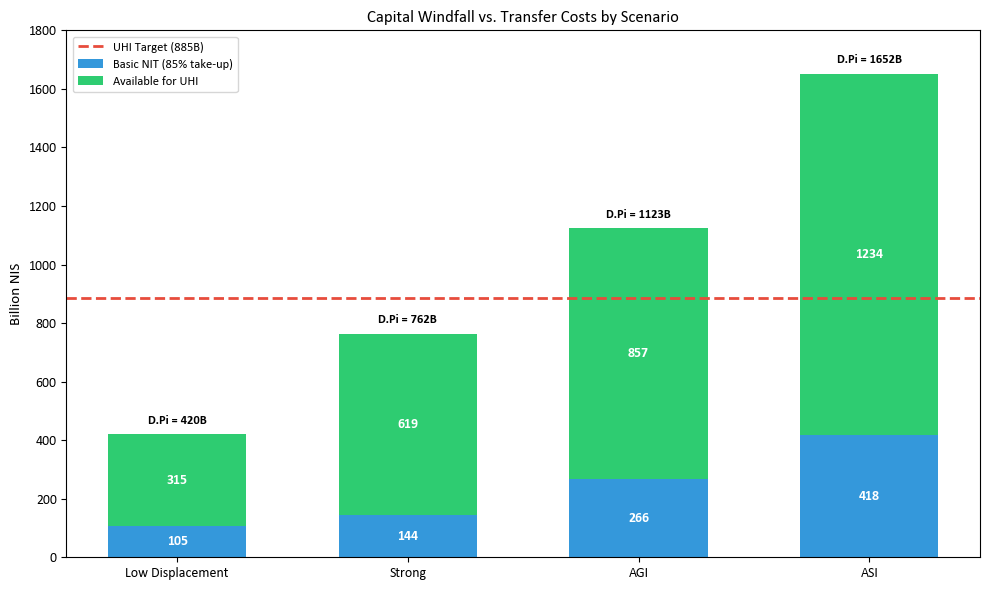

Saved: ..\Paper\Figures\fig6_capture_gap.pdf

CAPTURE GAP SUMMARY (85% take-up costs)
Scenario           D.Pi     NIT Cost    Available       vs UHI
------------------------------------------------------------
  Low Displacement       420B         105B         315B       -465B
  Strong           762B         144B         619B       -122B
**AGI             1123B         266B         857B       +239B
**ASI             1652B         418B        1234B       +767B
------------------------------------------------------------
UHI Target: 885B
Note: NIT costs shown at 85% take-up (budget-balanced)
      AGI = decision scenario; ASI = stress test


In [11]:
# Figure 6: Capture Gap Waterfall (Paper Figure 6)

# Create Figures directory
FIGURES_DIR = Path('../Paper/Figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Style settings (matching other figures)
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Calibri', 'Arial', 'Helvetica'],
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'legend.fontsize': 9,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

print("=" * 70)
print("4.7 CAPTURE GAP FIGURE")
print("=" * 70)

# =============================================================================
# DATA - ALL SCENARIOS (including ASI)
# =============================================================================

Y0 = get('Y0')
s_L = get('labor_share')
s_K = 1 - s_L

scenarios = ['Low Displacement', 'Strong', 'AGI', 'ASI']
Y1_values = [get('Y_1_low_displacement'), get('Y_1_strong'), get('Y_1_agi'), get('Y_1_asi')]
s_L_primes = [get('s_L_prime_low_displacement'), get('s_L_prime_strong'), get('s_L_prime_agi'), get('s_L_prime_asi')]

# NIT cost at 85% take-up (budget-balanced) - PRIMARY cost metric
nit_costs = [get('cost_at_takeup_low_displacement'), get('cost_at_takeup_strong'), 
             get('cost_at_takeup_agi'), get('cost_at_takeup_asi')]

# Calculate capital windfall for each scenario
delta_Pi_values = []
for Y1, s_L_p in zip(Y1_values, s_L_primes):
    s_K_p = 1 - s_L_p
    delta_Pi = s_K_p * Y1 - s_K * Y0
    delta_Pi_values.append(delta_Pi)

# Use target_cost variable from section 4.5b (already calculated above)
uhi_target = target_cost

# =============================================================================
# CREATE CLEAN STACKED BAR CHART
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

# Colors matching existing figures (fig3_revenue_waterfall)
color_nit = '#3498db'      # Blue - Basic NIT (locked in)
color_available = '#2ecc71' # Green - Available beyond NIT

x = range(len(scenarios))
width = 0.6

for i, (scenario, delta_Pi, nit_cost) in enumerate(zip(scenarios, delta_Pi_values, nit_costs)):
    available = delta_Pi - nit_cost  # What remains after basic NIT
    
    # Stack: Basic NIT (blue) + Available beyond NIT (green)
    ax.bar(i, nit_cost, width, color=color_nit, label='Basic NIT (85% take-up)' if i == 0 else '')
    ax.bar(i, available, width, bottom=nit_cost, color=color_available, 
           label='Available for UHI' if i == 0 else '')
    
    # Labels inside bars
    ax.text(i, nit_cost/2, f'{nit_cost:.0f}', ha='center', va='center', 
            fontsize=10, fontweight='bold', color='white')
    if available > 50:  # Only label if segment is large enough
        ax.text(i, nit_cost + available/2, f'{available:.0f}', ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')
    
    # Total label above
    ax.text(i, delta_Pi + 30, f'D.Pi = {delta_Pi:.0f}B', ha='center', va='bottom',
            fontsize=9, fontweight='bold')

# Add UHI target line
ax.axhline(y=uhi_target, color='#e74c3c', linestyle='--', linewidth=2, label=f'UHI Target ({uhi_target:.0f}B)')

ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.set_ylabel('Billion NIS')
ax.set_title('Capital Windfall vs. Transfer Costs by Scenario')
ax.set_ylim(0, 1800)  # Increased to accommodate ASI
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig6_capture_gap.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig6_capture_gap.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig6_capture_gap.pdf'}")

print("")
print("=" * 70)
print("CAPTURE GAP SUMMARY (85% take-up costs)")
print("=" * 70)
print(f"{'Scenario':<12} {'D.Pi':>10} {'NIT Cost':>12} {'Available':>12} {'vs UHI':>12}")
print("-" * 60)
for scenario, delta_Pi, nit_cost in zip(scenarios, delta_Pi_values, nit_costs):
    available = delta_Pi - nit_cost
    gap = delta_Pi - uhi_target
    gap_str = f"+{gap:.0f}B" if gap >= 0 else f"{gap:.0f}B"
    marker = "**" if scenario in ("AGI", "ASI") else "  "
    print(f"{marker}{scenario:<10} {delta_Pi:>9.0f}B {nit_cost:>11.0f}B {available:>11.0f}B {gap_str:>11}")
print("-" * 60)
print(f"UHI Target: {uhi_target:.0f}B")
print("Note: NIT costs shown at 85% take-up (budget-balanced)")
print("      AGI = decision scenario; ASI = stress test")
print("=" * 70)

---
# Summary

In [12]:
print("\n" + "=" * 70)
print("LAYER 4 SUMMARY")
print("=" * 70)

print(f"\nKey Results:")
print(f"")
print(f"  1. Estate Tax Revenue ({tau_estate*100:.0f}% on top decile):")
print(f"     - Wealth base: {wealth_top_decile/1000:.2f}T NIS (top decile)")
print(f"     - Annual flow: {annual_inheritance_flow:.1f}B NIS/year (at μ={mu_inheritance*100:.0f}%)")
print(f"     - Tax revenue: {estate_tax_revenue:.1f}B NIS/year")
print(f"")
print(f"  2. Data Dividend (0.10 NIS/GB, 2.5× gas benchmark):")
print(f"     - Natural gas benchmark: {gas_rate:.2f} NIS/m³")
print(f"     - Household data (2030): {data_per_hh/1000:.0f} TB/month")
print(f"     - Revenue: {data_dividend_calc:.1f}B NIS/year")
print(f"")
print(f"  3. Pillar Two Expansion (15% → 23%):")
print(f"     - MNE tax loss (0.3% GDP at Y₁): {pillar_two_mne_only:.1f}B NIS/year")
print(f"     - NVIDIA-type cases: {nvidia_annual:.0f}B NIS/year (recurring)")
print(f"     - Total: {pillar_two_total:.1f}B NIS/year")
print(f"")
print(f"  4. Yozma 2.0 Government VC Fund:")
print(f"     - Initial investment: {vc_initial:.0f}B NIS")
print(f"     - Gross IRR: {vc_gross_irr*100:.1f}% (Israeli VC avg)")
print(f"     - Value in 2030: {vc_final_value:.1f}B NIS ({growth_factor:.2f}×)")
print(f"     - 5% dividend: {vc_annual_dividend:.1f}B NIS/year")
print(f"")
print(f"  5. Channel 3 Funding Total:")
print(f"     - Total funding: {total:.1f}B NIS")
print(f"     - Target cost: {target_cost}B NIS")
print(f"     - Windfall levy needed: {windfall_levy:.1f}B ({windfall_levy/delta_Pi*100:.1f}% of ΔΠ)")
print(f"")
print(f"  6. Data Sources:")
print(f"     - Wealth: Berl Institute 2020")
print(f"     - Inheritance: Piketty (2010)")
print(f"     - Gas benchmark: Israel Natural Gas Authority 2024")
print(f"     - Data usage: Jerusalem Post 2025")
print(f"     - Pillar Two: BOI 2024, Globes (NVIDIA)")
print(f"     - VC returns: OECD Benchmarking VC - Israel")
print(f"     - Consolidation: Kohelet Policy Forum")
print(f"")
print(f"All parameters stored to calc_outputs.json via store().")


LAYER 4 SUMMARY

Key Results:

  1. Estate Tax Revenue (30% on top decile):
     - Wealth base: 3.25T NIS (top decile)
     - Annual flow: 97.5B NIS/year (at μ=3%)
     - Tax revenue: 29.2B NIS/year

  2. Data Dividend (0.10 NIS/GB, 2.5× gas benchmark):
     - Natural gas benchmark: 0.04 NIS/m³
     - Household data (2030): 1 TB/month
     - Revenue: 3.6B NIS/year

  3. Pillar Two Expansion (15% → 23%):
     - MNE tax loss (0.3% GDP at Y₁): 8.6B NIS/year
     - NVIDIA-type cases: 10B NIS/year (recurring)
     - Total: 18.6B NIS/year

  4. Yozma 2.0 Government VC Fund:
     - Initial investment: 50B NIS
     - Gross IRR: 17.5% (Israeli VC avg)
     - Value in 2030: 112.0B NIS (2.24×)
     - 5% dividend: 3.1B NIS/year

  5. Channel 3 Funding Total:
     - Total funding: 884.8B NIS
     - Target cost: 884.7915214480391B NIS
     - Windfall levy needed: 443.2B (26.8% of ΔΠ)

  6. Data Sources:
     - Wealth: Berl Institute 2020
     - Inheritance: Piketty (2010)
     - Gas benchmark: Isra